In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_log_error
from xgboost import plot_importance
from xgbtune import tune_xgb_model

import warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [3]:
btc_df = pd.read_csv(r'sentiment_btc.csv', index_col=0)
eth_df = pd.read_csv(r'sentiment_eth.csv', index_col=0)
price_df = pd.read_csv(r'Prices.csv', index_col=0)

In [4]:
price_df = price_df['2020-01-01 00:00:00':'2020-05-30 00:00:00']
price_df.index = pd.to_datetime(price_df.index, utc=True)
price_df = price_df.sort_values(by='Date')
price_df.index = price_df.index.date
price_df.index.name = 'Date'

## *

In [5]:
def PreProc(df, price_df=price_df):
    df['Date'] = pd.to_datetime(df['Date'], utc=False)
    df = df.set_index('Date')

    df = df.drop(columns='Tweet', axis=0)
    df = df.sort_values('Date')

    df.index = df.index.date
    df.index.name = 'Date'

    df['Impact'] = 2*df['Retweet']*df['classes'] + df['Likes']*df['classes']
    df = pd.get_dummies(df, columns=['classes'])

    merge_df = df.groupby('Date')[['Impact', 'classes_-1', 'classes_1']].sum()
    temp = df.groupby('Date')[['roberta_neg', 'roberta_neu', 'roberta_pos']].sum()
    merge_df = merge_df.merge(temp, on='Date')
    merge_df = pd.merge(merge_df, price_df, on='Date')

    return merge_df

In [6]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

In [7]:
def split_plot(train, test, crypto):
    fig, ax = plt.subplots(figsize=(17, 8))
    train[f'{crypto}_close'].plot(ax=ax, label='Training Set')
    test[f'{crypto}_close'].plot(ax=ax, label='Test Set')
    ax.axvline('2020-04-30', color='black', ls='--')
    ax.axvline('2020-05-01', color='black', ls='--')
    plt.legend()
    plt.title(crypto)
    plt.show()

In [8]:
def model(x_train, y_train, x_test, y_test):
    params = {'eval_metric': 'rmsle'}
    params, round_count = tune_xgb_model(params,x_train, y_train)

    regressor=xgb.XGBRegressor(**params)

    regressor.fit(x_train, y_train)

    predictions = regressor.predict(x_test)

    RMSLE = np.sqrt( mean_squared_log_error(y_test, predictions) )
    print("The score is %.5f" % RMSLE )

    plt.rcParams.update({'font.size': 16})

    fig, ax = plt.subplots(figsize=(12,6))
    plot_importance(regressor, max_num_features=8, ax=ax)
    plt.show()

    predictions = pd.DataFrame({'Date':x_test.index, 'pred':predictions})
    predictions['Date'] = pd.to_datetime(predictions['Date'], utc=False)
    predictions = predictions.set_index('Date')

    fig = plt.figure(figsize=(20, 5))
    sns.lineplot(data=y_test, color='r', label='actual', alpha=0.6)
    sns.lineplot(data=predictions, alpha=0.6)
    plt.show()

## **

In [9]:
btc_merge = PreProc(btc_df)
btc_merge = btc_merge.iloc[:, [0, 1, 2, 3, 4, 5, 6, 8, 10, 12]]
btc_merge.head()

,Impact,classes_-1,classes_1,roberta_neg,roberta_neu,roberta_pos,+1D BTC,Price Diff BTC,BTC Volume,BTC_close
Date,,,,,,,,,,
2020-01-01,12907,10,38,12.733392,34.907594,39.359014,0,-214.704392,1.856566e+10,7200.174393
2020-01-02,12894,12,33,15.648257,37.385984,34.965757,1,359.414183,2.080208e+10,6985.470001
2020-01-03,26914,13,52,15.162614,40.917994,50.919391,1,65.772383,2.811148e+10,7344.884183
2020-01-04,9551,11,24,12.365561,28.783707,24.850731,1,0.660760,1.844427e+10,7410.656566
2020-01-05,18484,16,26,17.017796,36.344830,28.637374,1,357.901712,1.972507e+10,7411.317327


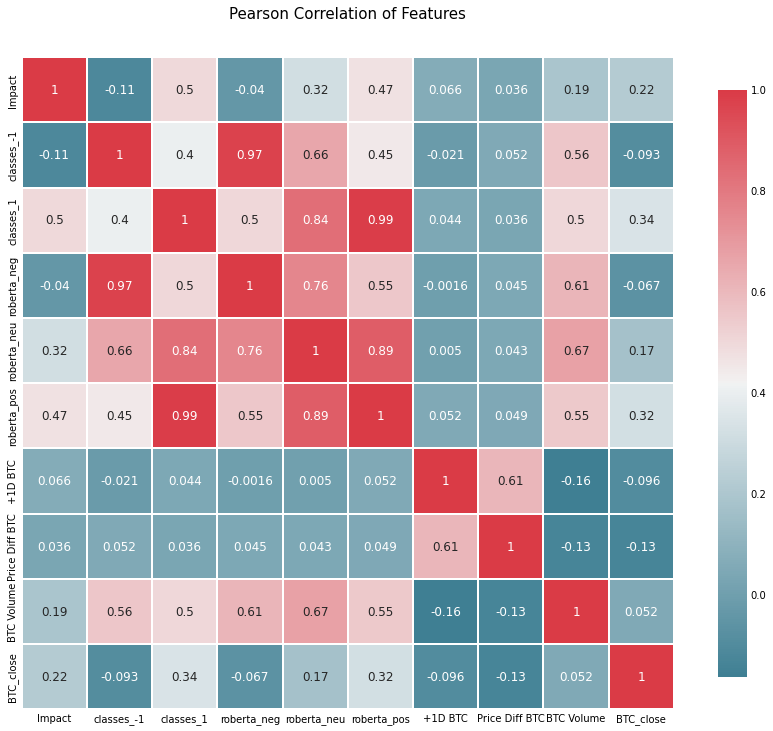

In [10]:
correlation_heatmap(btc_merge)

In [11]:
eth_merge = PreProc(eth_df)
eth_merge = eth_merge.iloc[:, [0, 1, 2, 3, 4, 5, 7, 9, 11, 13]]
eth_merge.head()

,Impact,classes_-1,classes_1,roberta_neg,roberta_neu,roberta_pos,+1D ETH,Price Diff ETH,ETH Volume,ETH_close
Date,,,,,,,,,,
2020-01-01,3861,6,13,6.510046,15.260750,15.229204,0,-3.391826,7.935230e+09,130.802008
2020-01-02,7842,5,21,6.674448,16.394974,20.930578,1,6.761530,8.032709e+09,127.410182
2020-01-03,1949,12,15,10.536510,19.683803,15.779686,1,0.897659,1.047685e+10,134.171712
2020-01-04,5116,1,14,3.152349,13.243627,12.604023,1,1.207405,7.430905e+09,135.069371
2020-01-05,6867,6,11,6.964404,14.396745,12.638852,1,8.027377,7.526675e+09,136.276777


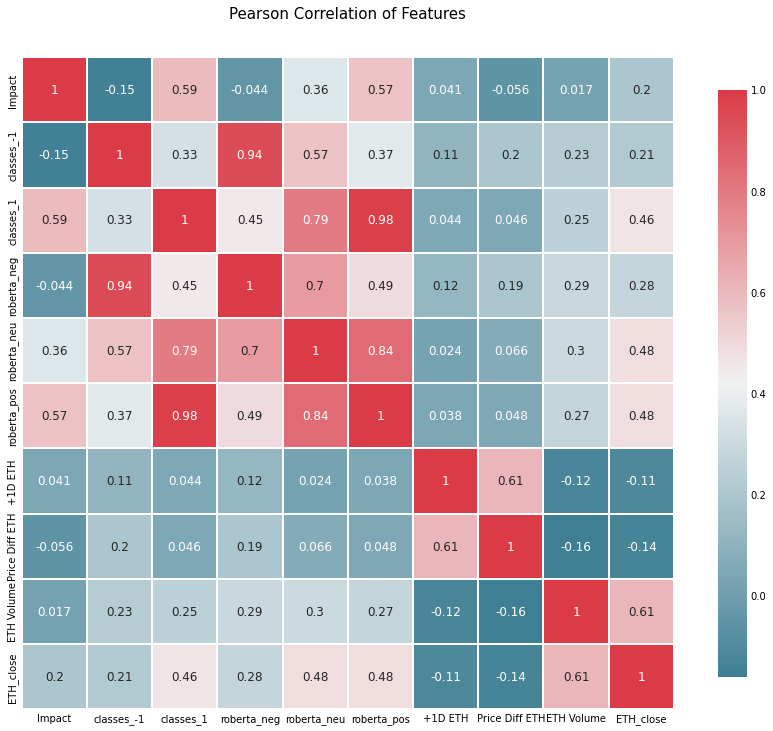

In [12]:
correlation_heatmap(eth_merge)

## ***

In [13]:
date1 = pd.to_datetime('2020-04-30').date()
date2 = pd.to_datetime('2020-05-01').date()

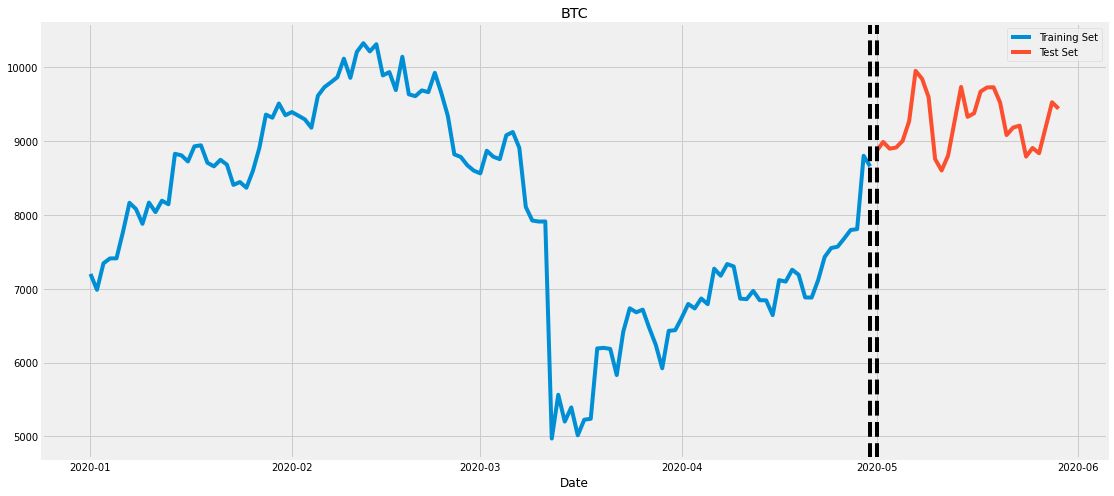

In [14]:
train_btc = btc_merge[:date1]
test_btc = btc_merge[date2:]
split_plot(train_btc, test_btc, 'BTC')
test_btc = btc_merge

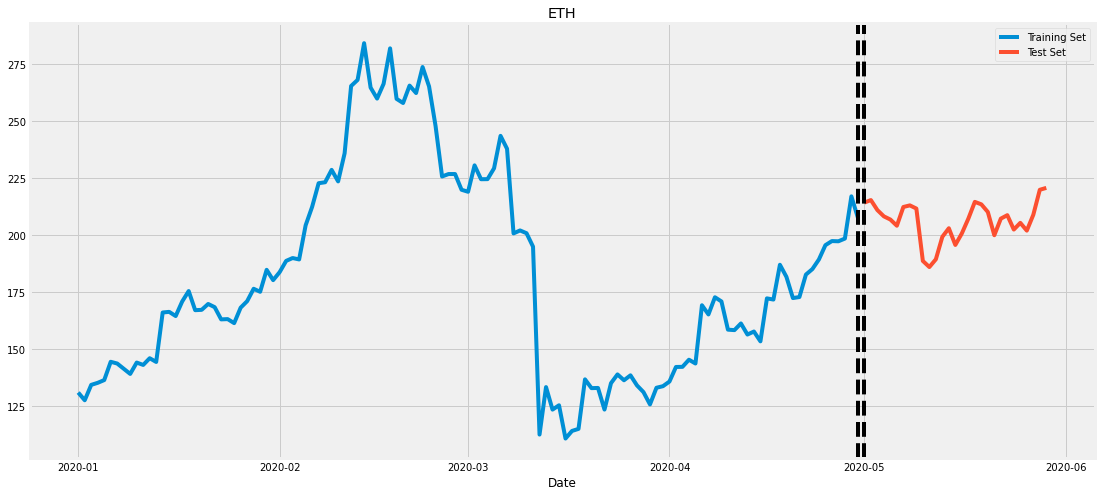

In [15]:
train_eth = eth_merge[:date1]
test_eth = eth_merge[date2:]
split_plot(train_eth, test_eth, 'ETH')
test_eth = eth_merge

## ****

In [16]:
x_train_btc = train_btc.drop(['Impact','BTC_close', 'Price Diff BTC', '+1D BTC'], axis=1) 
y_train_btc = train_btc['BTC_close']
x_test_btc = test_btc.drop(['Impact','BTC_close', 'Price Diff BTC', '+1D BTC'], axis=1) 
y_test_btc = test_btc['BTC_close']

x_train_eth = train_eth.drop(['ETH_close', 'Price Diff ETH', '+1D ETH'], axis=1) 
y_train_eth = train_eth['ETH_close']
x_test_eth = test_eth.drop(['ETH_close', 'Price Diff ETH', '+1D ETH'], axis=1) 
y_test_eth = test_eth['ETH_close']

tuning pass 0...
computing best round...
best round: 10
tuning max_depth and min_child_weight ...
best loss: 0.0573
best max_depth: 8
best min_child_weight: 1
tuning gamma ...
best loss: 0.0573
best gamma: 0.0
re-computing best round...
best round: 10
tuning subsample and colsample_bytree ...
best loss: 0.0573
best subsample: 1.0
best colsample_bytree: 1.0
fine tuning subsample and colsample_bytree ...
best loss: 0.0573
best subsample: 1.0
best colsample_bytree: 1.0
tuning alpha and lambda ...
best loss: 0.0573
best alpha: 0
best lambda: 1
tuning seed ...
best loss: 0.0573
best seed: 0
{'eval_metric': 'rmsle', 'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.0, 'subsample': 1.0, 'colsample_bytree': 1.0, 'alpha': 0, 'lambda': 1, 'seed': 0}
tuning pass 1...
computing best round...
best round: 11
tuning max_depth and min_child_weight ...
best loss: 0.0453
best max_depth: 8
best min_child_weight: 1
tuning gamma ...
best loss: 0.0453
best gamma: 0.0
re-computing best round...
best round: 1

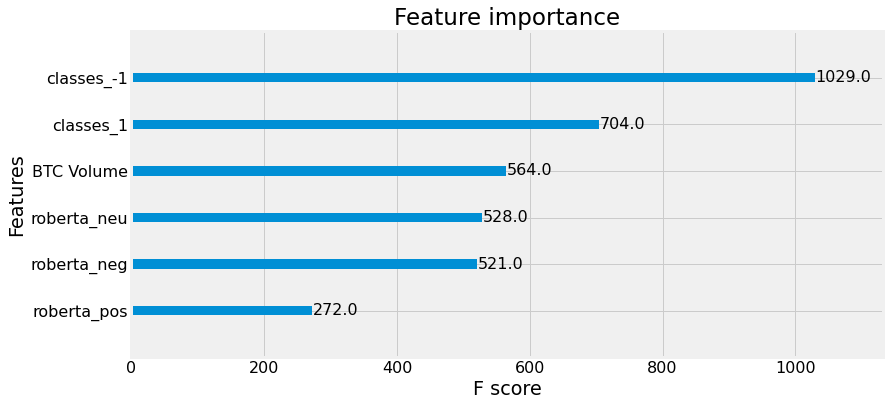

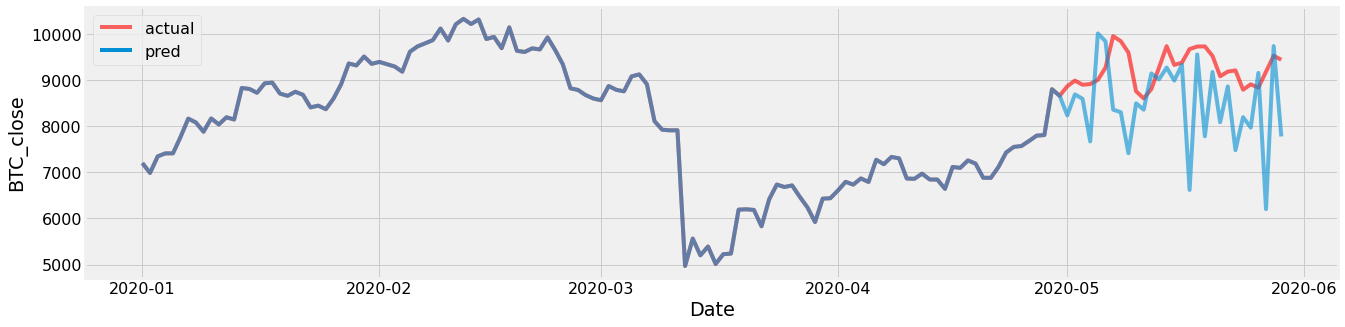

In [17]:
model(x_train_btc, y_train_btc, x_test_btc, y_test_btc)

tuning pass 0...
computing best round...
best round: 23
tuning max_depth and min_child_weight ...
best loss: 0.0048
best max_depth: 8
best min_child_weight: 1
tuning gamma ...
best loss: 0.0046
best gamma: 0.4
re-computing best round...
best round: 23
tuning subsample and colsample_bytree ...
best loss: 0.0044
best subsample: 1.0
best colsample_bytree: 0.9
fine tuning subsample and colsample_bytree ...
best loss: 0.0044
best subsample: 1.0
best colsample_bytree: 0.9
tuning alpha and lambda ...
best loss: 0.0044
best alpha: 0
best lambda: 1
tuning seed ...
best loss: 0.0043
best seed: 7
{'eval_metric': 'rmsle', 'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.4, 'subsample': 1.0, 'colsample_bytree': 0.9, 'alpha': 0, 'lambda': 1, 'seed': 7}
tuning pass 1...
computing best round...
best round: 15
tuning max_depth and min_child_weight ...
best loss: 0.018
best max_depth: 8
best min_child_weight: 1
tuning gamma ...
best loss: 0.018
best gamma: 0.0
re-computing best round...
best round: 15


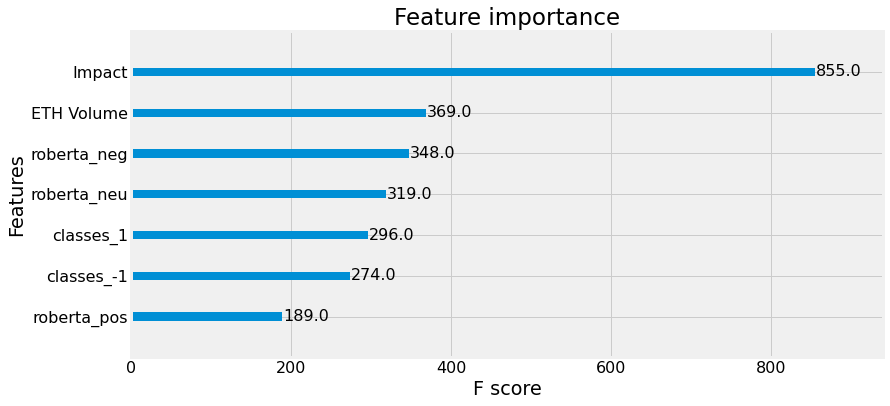

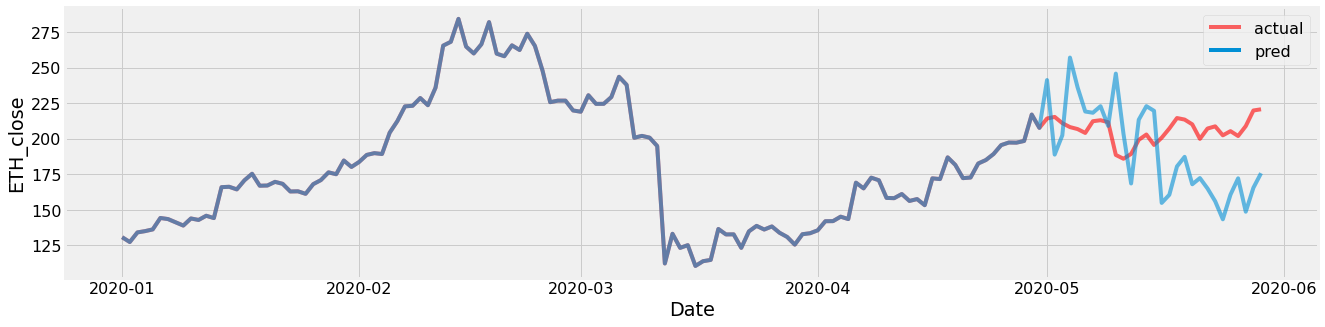

In [18]:
model(x_train_eth, y_train_eth, x_test_eth, y_test_eth)